This year's International Women's Day asks its participants to challenge the world in order to change it (#ChooseToChallenge). There are many pieces of the current partiarchial system that can be challenged, but in the following simulation we seek to challenge the fact that women in the United States are more likely to be impoverished than men. In the following analysis, we propose a Universal Basic Income (UBI), funded by a flat income tax, as a possible solution for both alleviating poverty and narrowing the gendered poverty gap.    

In [92]:
import microdf as mdf
import numpy as np
import pandas as pd
import plotly.express as px
import ubicenter 


In [93]:
df = pd.read_csv("https://github.com/MaxGhenis/datarepo/raw/master/pppub20.csv.gz", 
                 usecols=["MARSUPWT", "SPM_RESOURCES", "SPM_POVTHRESHOLD",
                          "SPM_WEIGHT", "SPM_NUMPER", "A_SEX", "A_AGE",
                          "SPM_ID", "AGI"])

In [94]:
df.columns = df.columns.str.lower()

In [95]:
df["weight"] = df.marsupwt / 100
df["spm_weight"] = df.spm_weight / 100
df["female"] = df.a_sex == 2
df["poverty"] = df.spm_resources < df.spm_povthreshold
df["sex"] = np.where(df.female, "Female", "Male")

In [96]:
spm = df.groupby(["spm_id", "spm_resources", "spm_weight", "spm_povthreshold",
                  "spm_numper"])[["agi"]].sum()
spm["agi_pos"] = np.maximum(spm.agi, 0)
spm.reset_index(inplace = True)

In [97]:
total_population = df.weight.sum()
total_agi_pos = mdf.weighted_sum(spm, "agi_pos", "spm_weight")

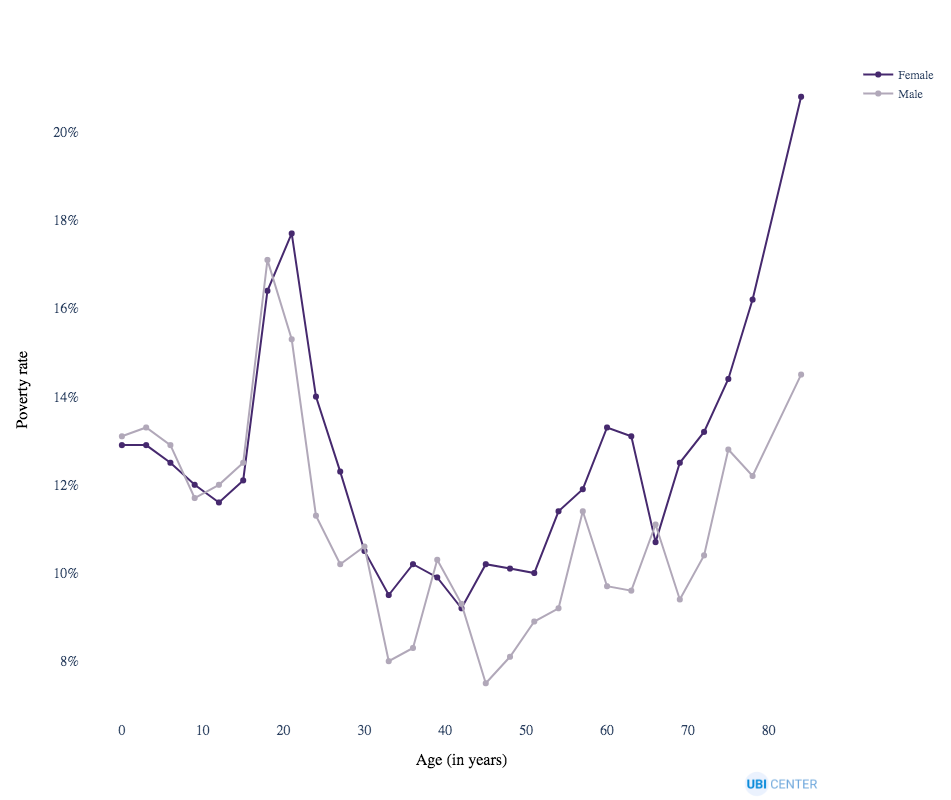

In [98]:
# Bin into ages aligning with 18 year old threshold.
LIGHT_PURPLE = "#907EA8"
DARK_PURPLE = "#46296E"
LIGHT_GREY = "#DAD4E2"
DARK_GREY = "#B1A8B9"



df["age_group"] = pd.cut(df.a_age, np.arange(0, 88, 3), 
                         labels = np.arange(0, 85, 3))
pov_age = mdf.weighted_mean(df, "poverty", "marsupwt",
                            groupby = ["age_group", "sex"]).reset_index()                      
pov_age.rename({0: "poverty"}, axis=1, inplace = True) 
pov_age.poverty = 100 * pov_age.poverty.round(3)

fig = px.line(pov_age, x = "age_group", y = "poverty", 
              color = "sex", 
              color_discrete_map={"Female": DARK_PURPLE, "Male": DARK_GREY})
fig.update_layout(
    xaxis_title="Age (in years)",
    yaxis_title="Poverty rate",
    legend_title = "", 
    yaxis_ticksuffix="%")

fig.update_traces(mode="markers+lines", hovertemplate=None)

ubicenter.format_fig(fig)

The figure above shows the poverty rate for women as compared to men on the household level by age. Before 18, the rates are roughly similar, first diverging at the young adult mark. 

In the following figure, we show the poverty rate for women and men after a monthly UBI, ranging from $100 to $1000 a month. In order to better observe the effect on the gender difference, we only include those 18 and older in our analysis. As we showed above, the poverty rates for those under 18 are relatively equivalent. The UBI would still be universal, distributed on the individual level to all ages. 



In [99]:
def pov(female, monthly_ubi):
    # Calculate poverty rates for a gender subset given a monthly UBI amount.
    cost = monthly_ubi * total_population * 12 
    tax_rate = cost / total_agi_pos  # Divide by positive AGI.
    spm["new_resources"] = (
        spm.spm_resources - 
        tax_rate * spm.agi_pos + 
        (12 * monthly_ubi * spm.spm_numper))
    person = df[(df.female == female) & (df.a_age > 17)].merge(spm[["spm_id", "new_resources"]], on="spm_id")
    return pd.Series(dict(
        pov=mdf.poverty_rate(person, income = "new_resources",
                             threshold = "spm_povthreshold", w = "weight"),
        deep_pov=mdf.deep_poverty_rate(person, income = "new_resources",
                                       threshold = "spm_povthreshold",
                                       w = "weight")))
   
def pov_row(row): 
    return pov(row.female, row.monthly_ubi)

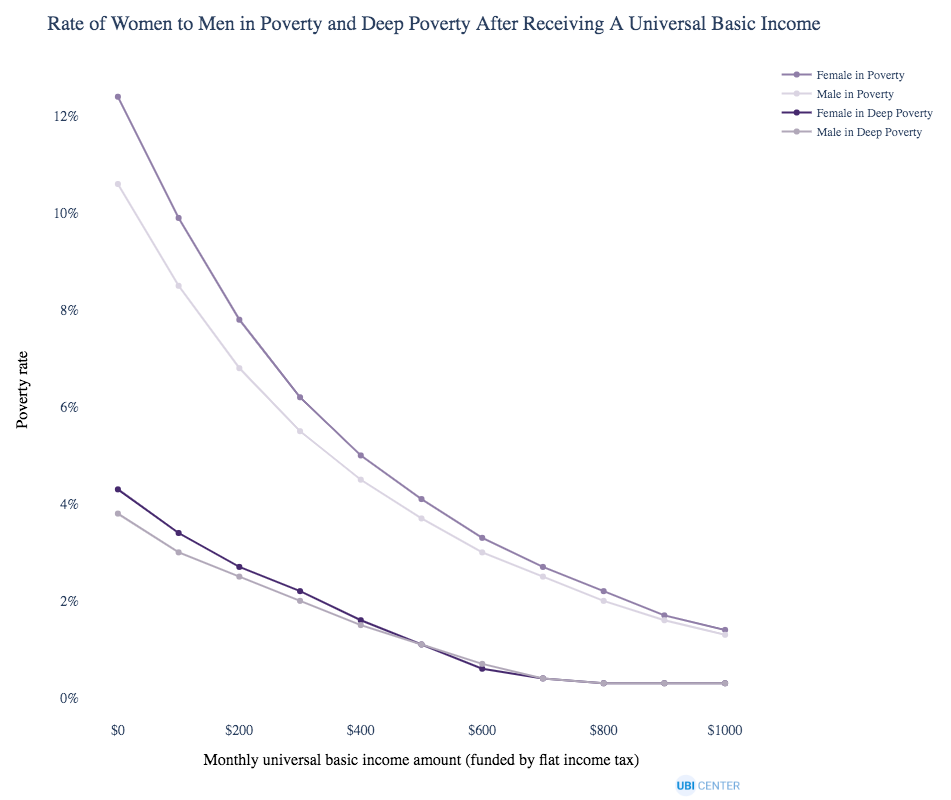

In [100]:
gender_ubi = mdf.cartesian_product({"female" : [True , False], 
                                    "monthly_ubi" : np.arange(0, 1001, 100)})
gender_ubi = pd.concat([gender_ubi, gender_ubi.apply(pov_row, axis=1)], axis=1)

gender_ubi_long = gender_ubi.melt(id_vars=["female", "monthly_ubi"], 
                                  value_vars=["pov", "deep_pov"])
gender_ubi_long["label"] = pd.Series(np.where(gender_ubi_long.female,
                                                                   "Female", "Male"))+ " in " + pd.Series(np.where(gender_ubi_long.variable == "pov", "Poverty", "Deep Poverty"))                                
gender_ubi_long.value = 100 * gender_ubi_long.value.round(3)

fig = px.line(gender_ubi_long, x = "monthly_ubi", y = "value", color = "label", 
              color_discrete_map={"Female in Poverty": LIGHT_PURPLE,
                                  "Female in Deep Poverty": DARK_PURPLE,
                                  "Male in Poverty": LIGHT_GREY,
                                  "Male in Deep Poverty": DARK_GREY})

fig.update_layout(
    title="Rate of Women to Men in Poverty and Deep Poverty After Receiving A Universal Basic Income",
    xaxis_title="Monthly universal basic income amount (funded by flat income tax)",
    xaxis_tickprefix="$",
    yaxis_title="Poverty rate", 
    legend_title = "", 
    yaxis_ticksuffix="%")

fig.update_traces(mode="markers+lines", hovertemplate=None)
ubicenter.format_fig(fig)


In [101]:
gender_ratio = gender_ubi.pivot_table(values = "pov",
                                      index = ["monthly_ubi"],
                                      columns = "female").reset_index()
gender_ratio.rename({True : "female", False : "male"}, axis = 1, inplace = True)
gender_ratio["ratio"] = gender_ratio.female / gender_ratio.male
gender_ratio["poverty_type"] = "Poverty"
deep_gender_ratio = gender_ubi.pivot_table(values = "deep_pov",
                                      index = ["monthly_ubi"],
                                      columns = "female").reset_index()
deep_gender_ratio.rename({True : "female", False : "male"}, axis = 1, inplace = True)
deep_gender_ratio["ratio"] = deep_gender_ratio.female / deep_gender_ratio.male
deep_gender_ratio["poverty_type"] = "Deep Poverty"

deep_gender_ratio.ratio = deep_gender_ratio.ratio.round(3)


gender_ratios = pd.concat([gender_ratio, deep_gender_ratio])

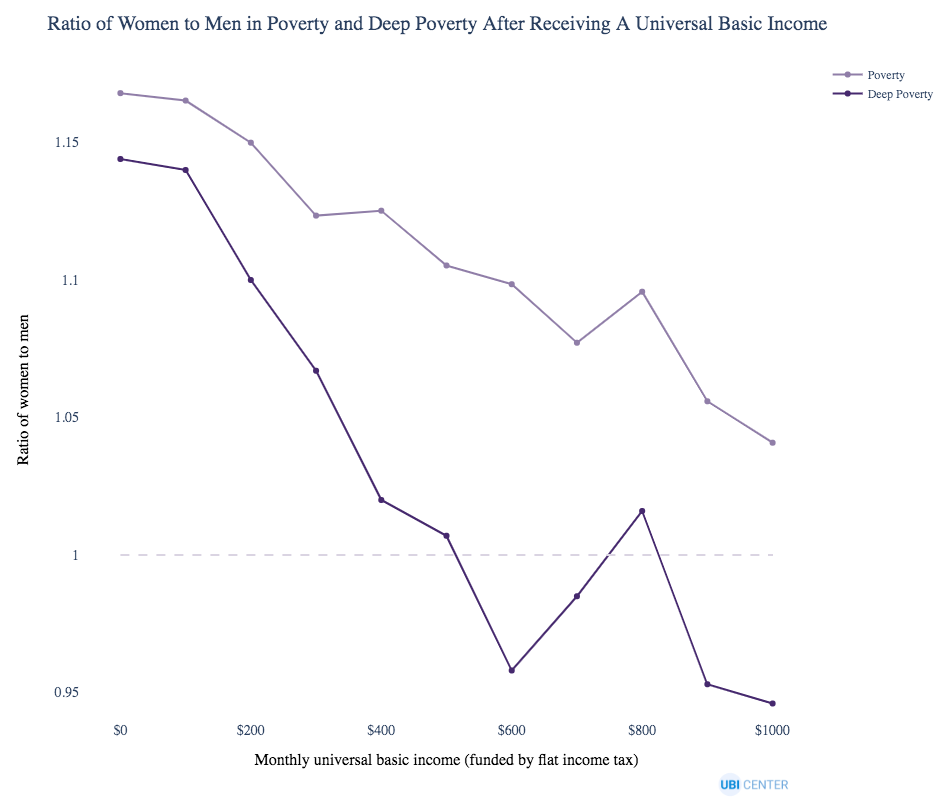

In [102]:
fig = (px.line(gender_ratios, x = "monthly_ubi", y = "ratio", color="poverty_type",
               color_discrete_map={"Poverty": LIGHT_PURPLE, "Deep Poverty": DARK_PURPLE}))


fig.update_yaxes(range= [0.94, 1.18])
fig.add_shape(type='line',
                x0=0,
                y0=1,
                x1=1000,
                y1=1,
                line=dict(color = LIGHT_GREY, dash = 'dash'),
                xref='x',
                yref='y')

fig.update_layout(
    title="Ratio of Women to Men in Poverty and Deep Poverty After Receiving A Universal Basic Income",
    xaxis_title="Monthly universal basic income (funded by flat income tax)",
    xaxis_tickprefix="$",
    yaxis_title="Ratio of women to men", 
    legend_title = "")

fig.update_traces(mode="markers+lines", hovertemplate=None)
ubicenter.format_fig(fig)


As shown in the above figure, a UBI distributed at the individual level would significantly alleviate poverty, specifically gendered poverty.  

Though our modeling offeres promising results, it does not tell the full story. Firstly, the rate of poverty varies greatly when both race and gender are taken into account together. As seen in our blog post on [MLK day](https://blog.ubicenter.org/20210118/racial-poverty-disparities-mlk-day-2021.html), the rate of poverty for Black American households is significantly higher than for white Americans households. Though it is often cited that women in the US make only 81 cents to the dollar of white men, the [wage gap widens ](https://www.payscale.com/data/gender-pay-gap) significantly for women of color. This intersection of race and gender is one we hope to model in future analysis.  

Secondly, there are numerous and conflating reasons that women are more likely to be in poverty than men. A UBI by itself is not a silver bullet for gendered poverty or socioeconomic equality. Even so, a UBI could contribute to greater policy and social changes to establish gender equity. For example, as compared to child allowances or childcare subsidies, UBI offers more flexibility in choice and creates a greater potential for shared responsibility of caretaking duties. But an equal distribution of caretaking work also require, "wider availability of part-time work and job-sharing; periodic leave for full-time caregiving; the decoupling of access to benefits like health insurance and pensions from paid employment; the widespread availability of care centers" to name a few. (Zellecke Institutionalizing the Universal Caretaker Through a Basic Income?) In this way, a UBI is necessary but not sufficient.     

Still, our analysis suggests that a UBI could be a relevant ingredient in the greater movement for the social, economic, and political equality of women. 
